# SoundScapify - Song Recommender based on Soundscape (Part 3 of 4)

This is the third part of the notebooks:  
1. Introduction and Train Dataset EDA
2. Model Training
3. **Model Prediction with Test Dataset**
4. Song Dataset Retrieval

## Import Packages and Dataset

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
import warnings
import librosa
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix

### Preprocessing Test Dataset

In [2]:
df_test = pd.read_csv('csv/fold1_test.csv', sep='\t')
df_test.head()

,filename
0,audio/airport-barcelona-203-6129-0-a.wav
1,audio/airport-barcelona-203-6129-1-a.wav
2,audio/airport-barcelona-203-6129-2-a.wav
3,audio/airport-barcelona-203-6129-3-a.wav
4,audio/airport-barcelona-203-6129-4-a.wav


In [3]:
df_test.shape

(29680, 1)

In [4]:
# create scene_label & log_melspectrogram column to hold the melspectrogram array 
df_test['scene_label'] = pd.Series(dtype='object')
df_test['log_melspectrogram'] = pd.Series(dtype='object')

In [5]:
label_dict = {'park': 'park',
              'street_traffic': 'street_traffic',
              'metro': 'metro',
              'bus': 'bus',
             }

def LabelData(filedir):
    for text,label in label_dict.items():
        if text in filedir.lower():
            return label
    return None

In [6]:
# Apply LabelData function to the dataframe
df_test['scene_label'] = df_test['filename'].apply(LabelData)
df_test.head(15)

,filename,scene_label,log_melspectrogram
0,audio/airport-barcelona-203-6129-0-a.wav,None,NaN
1,audio/airport-barcelona-203-6129-1-a.wav,None,NaN
2,audio/airport-barcelona-203-6129-2-a.wav,None,NaN
3,audio/airport-barcelona-203-6129-3-a.wav,None,NaN
4,audio/airport-barcelona-203-6129-4-a.wav,None,NaN
5,audio/airport-barcelona-203-6129-5-a.wav,None,NaN
6,audio/airport-barcelona-203-6129-6-a.wav,None,NaN
7,audio/airport-barcelona-203-6129-7-a.wav,None,NaN
8,audio/airport-barcelona-203-6129-8-a.wav,None,NaN
9,audio/airport-barcelona-203-6129-9-a.wav,None,NaN


In [7]:
# drop rows without any scene label
df_test = df_test[df_test['scene_label'].notna()]
df_test

,filename,scene_label,log_melspectrogram
2960,audio/bus-barcelona-210-6406-0-a.wav,bus,NaN
2961,audio/bus-barcelona-210-6406-1-a.wav,bus,NaN
2962,audio/bus-barcelona-210-6406-2-a.wav,bus,NaN
2963,audio/bus-barcelona-210-6406-3-a.wav,bus,NaN
2964,audio/bus-barcelona-210-6406-4-a.wav,bus,NaN
...,...,...,...
26715,audio/street_traffic-lisbon-1171-45182-5-s6.wav,street_traffic,NaN
26716,audio/street_traffic-lisbon-1171-45182-6-s6.wav,street_traffic,NaN
26717,audio/street_traffic-lisbon-1171-45182-7-s6.wav,street_traffic,NaN
26718,audio/street_traffic-lisbon-1171-45182-8-s6.wav,street_traffic,NaN


In [8]:
# drop rows that is for metro_station
df_test = df_test[df_test['filename'].str.contains('metro_station') != True]
df_test

,filename,scene_label,log_melspectrogram
2960,audio/bus-barcelona-210-6406-0-a.wav,bus,NaN
2961,audio/bus-barcelona-210-6406-1-a.wav,bus,NaN
2962,audio/bus-barcelona-210-6406-2-a.wav,bus,NaN
2963,audio/bus-barcelona-210-6406-3-a.wav,bus,NaN
2964,audio/bus-barcelona-210-6406-4-a.wav,bus,NaN
...,...,...,...
26715,audio/street_traffic-lisbon-1171-45182-5-s6.wav,street_traffic,NaN
26716,audio/street_traffic-lisbon-1171-45182-6-s6.wav,street_traffic,NaN
26717,audio/street_traffic-lisbon-1171-45182-7-s6.wav,street_traffic,NaN
26718,audio/street_traffic-lisbon-1171-45182-8-s6.wav,street_traffic,NaN


In [9]:
df_test.reset_index(inplace= True, drop=True)
df_test

,filename,scene_label,log_melspectrogram
0,audio/bus-barcelona-210-6406-0-a.wav,bus,NaN
1,audio/bus-barcelona-210-6406-1-a.wav,bus,NaN
2,audio/bus-barcelona-210-6406-2-a.wav,bus,NaN
3,audio/bus-barcelona-210-6406-3-a.wav,bus,NaN
4,audio/bus-barcelona-210-6406-4-a.wav,bus,NaN
...,...,...,...
11875,audio/street_traffic-lisbon-1171-45182-5-s6.wav,street_traffic,NaN
11876,audio/street_traffic-lisbon-1171-45182-6-s6.wav,street_traffic,NaN
11877,audio/street_traffic-lisbon-1171-45182-7-s6.wav,street_traffic,NaN
11878,audio/street_traffic-lisbon-1171-45182-8-s6.wav,street_traffic,NaN


### Obtain Melspectrogram

In [10]:
def MelSpectrogram(i):
    #obtain audio file path
    AUDIO_FILE = df_test['filename'].iloc[i]
    
    #load audio file
    signal, sr = librosa.load(AUDIO_FILE)
    
    #obtain mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(signal, sr=sr, n_fft=2048, hop_length=512, n_mels=40)
    
    #change to dB scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram.T

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for i in tqdm(df_test.index, desc='Progress'):
        if type(df_test['log_melspectrogram'].iloc[i]) is not np.ndarray:
            df_test['log_melspectrogram'].iloc[i] = MelSpectrogram(i)

Progress: 100%|██████████| 11880/11880 [12:51<00:00, 15.39it/s]


In [14]:
pickle.dump(df_test, open('csv/clean_testdata.df','wb'))

## Preprocessing Data for Modelling

In [12]:
df_test = pickle.load(open('csv/clean_testdata.df', 'rb'))

In [13]:
df_test

,filename,scene_label,log_melspectrogram
0,audio/bus-barcelona-210-6406-0-a.wav,bus,"[[15.874739, 10.796704, 8.210971, 5.948248, 4...."
1,audio/bus-barcelona-210-6406-1-a.wav,bus,"[[19.80442, 8.151323, -1.0134977, -6.521938, -..."
2,audio/bus-barcelona-210-6406-2-a.wav,bus,"[[19.108807, 6.315139, -2.6570435, -5.467496, ..."
3,audio/bus-barcelona-210-6406-3-a.wav,bus,"[[20.328829, 11.800287, 0.14797902, -1.9814003..."
4,audio/bus-barcelona-210-6406-4-a.wav,bus,"[[27.740614, 11.900111, 0.70303327, -0.8866443..."
...,...,...,...
11875,audio/street_traffic-lisbon-1171-45182-5-s6.wav,street_traffic,"[[11.187963, 21.085938, 15.1520815, 9.684376, ..."
11876,audio/street_traffic-lisbon-1171-45182-6-s6.wav,street_traffic,"[[17.213293, 22.630634, 14.375606, 3.6936471, ..."
11877,audio/street_traffic-lisbon-1171-45182-7-s6.wav,street_traffic,"[[12.599348, 18.757893, 9.549774, 10.291174, 6..."
11878,audio/street_traffic-lisbon-1171-45182-8-s6.wav,street_traffic,"[[15.474168, 17.520737, 13.170336, 14.472099, ..."


### Label Encoding the `scene_label` Value (y_true)

In [14]:
classes = df_test['scene_label'].unique()

le = LabelEncoder()
le.fit(classes)

y_true = df_test['scene_label']
y_true = pd.Series(le.transform(y_true))
y_true

0        0
1        0
2        0
3        0
4        0
        ..
11875    3
11876    3
11877    3
11878    3
11879    3
Length: 11880, dtype: int32

In [48]:
y_true.value_counts()

0    2970
1    2970
2    2970
3    2970
dtype: int64

In [15]:
classes

array(['bus', 'metro', 'park', 'street_traffic'], dtype=object)

### The input data for the Model (X_test)

In [35]:
X_ev = df_test['log_melspectrogram']
X_ev

0        [[15.874739, 10.796704, 8.210971, 5.948248, 4....
1        [[19.80442, 8.151323, -1.0134977, -6.521938, -...
2        [[19.108807, 6.315139, -2.6570435, -5.467496, ...
3        [[20.328829, 11.800287, 0.14797902, -1.9814003...
4        [[27.740614, 11.900111, 0.70303327, -0.8866443...
                               ...                        
11875    [[11.187963, 21.085938, 15.1520815, 9.684376, ...
11876    [[17.213293, 22.630634, 14.375606, 3.6936471, ...
11877    [[12.599348, 18.757893, 9.549774, 10.291174, 6...
11878    [[15.474168, 17.520737, 13.170336, 14.472099, ...
11879    [[9.719199, 14.614855, 15.432425, 7.2881703, 2...
Name: log_melspectrogram, Length: 11880, dtype: object

In [29]:
X_test = df_test['log_melspectrogram'].apply(lambda x: np.expand_dims(x,axis=2))
X_test

0        [[[15.874739], [10.796704], [8.210971], [5.948...
1        [[[19.80442], [8.151323], [-1.0134977], [-6.52...
2        [[[19.108807], [6.315139], [-2.6570435], [-5.4...
3        [[[20.328829], [11.800287], [0.14797902], [-1....
4        [[[27.740614], [11.900111], [0.70303327], [-0....
                               ...                        
11875    [[[11.187963], [21.085938], [15.1520815], [9.6...
11876    [[[17.213293], [22.630634], [14.375606], [3.69...
11877    [[[12.599348], [18.757893], [9.549774], [10.29...
11878    [[[15.474168], [17.520737], [13.170336], [14.4...
11879    [[[9.719199], [14.614855], [15.432425], [7.288...
Name: log_melspectrogram, Length: 11880, dtype: object

In [30]:
X_test[0].shape

(44, 40, 1)

In [18]:
X_test = X_test.tolist()
X_test = np.array(X_test, dtype=np.float32)

In [19]:
X_test.shape

(11880, 44, 40, 1)

## Prediction on Test Dataset

In [20]:
model = load_model('models/LSTM.hdf5')
# model = pickle.load(open('models/LSTM_2.model','rb'))

In [34]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, melspectrograms, labels, n_classes,
                batch_size, shuffle=True):
        self.melspectrograms = melspectrograms
        self.labels = labels
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.melspectrograms) / self.batch_size))
    
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        melspectrogram = [np.asarray(self.melspectrograms[k]) for k in indexes]
        labels = [self.labels[k] for k in indexes]

        t = melspectrogram[0].shape[0]
        dB = melspectrogram[0].shape[1]
        
        # generate a batch of time data
        X = np.empty((self.batch_size, t, dB, 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
        
        for i, (mel, label) in enumerate(zip(melspectrogram, labels)):
            X[i,] = np.expand_dims(mel, axis=2)
            Y[i,] = to_categorical(label, num_classes=self.n_classes)
        
        return X, Y
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.melspectrograms))
        self.indexes = np.array(self.melspectrograms.index.tolist())
        
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [44]:
tg = DataGenerator(X_ev, y_true, 4, batch_size=32)

In [47]:
model.evaluate(tg, verbose=1)

371/371 [==============================] - 1s 4ms/step - loss: 1.9916 - accuracy: 0.5711


[1.9915565252304077, 0.5710916519165039]

**Remarks:** The accuracy of the test dataset is 0.5711 with loss value of 1.9916. The result is somewhat unexpected since the audio file came for the same source. This may due to the model overfit to the train dataset by a lot, resulting in a lower accuracy in test dataset.

In [21]:
y_pred = model.predict(X_test)

372/372 [==============================] - 4s 3ms/step


In [22]:
y_final = []

for pred in tqdm(y_pred, desc='Progress'):
    y_final.append(np.argmax(pred))

Progress: 100%|██████████| 11880/11880 [00:00<00:00, 594808.90it/s]


In [23]:
len(y_final)

11880

In [24]:
y_true_label = df_test['scene_label'].tolist()
y_pred_label = [classes[i] for i in y_final]

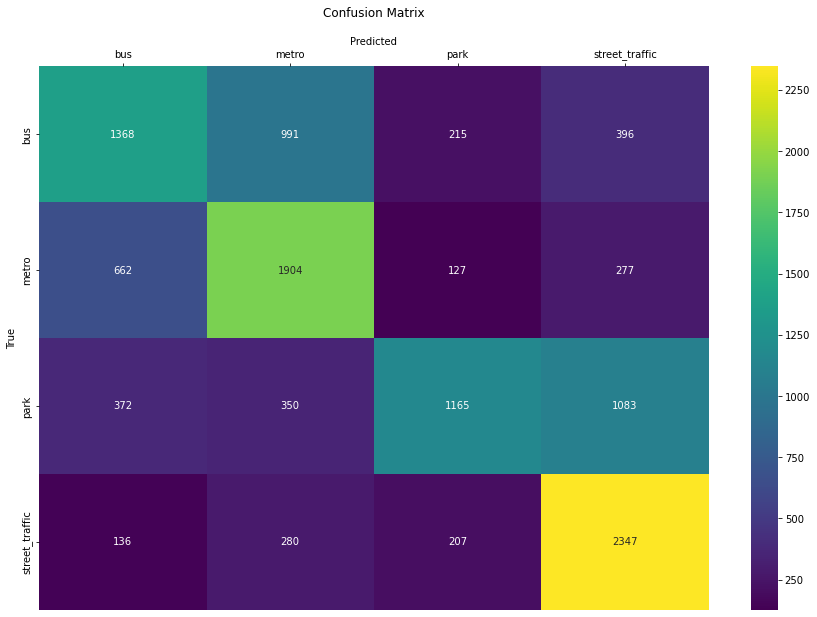

In [25]:
conf_mat = confusion_matrix(y_true_label, y_pred_label, labels=classes)

df_cm = pd.DataFrame(conf_mat, index = classes,
                     columns = classes)

f, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(df_cm, annot=True, cmap='viridis', fmt='g')

plt.title('Confusion Matrix', y=1.08)
plt.xlabel('Predicted')
plt.ylabel('True')

ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
plt.show()

**Observation :** 
- The model predicts fairly well based on the confusion matrix, where street_traffic has the best accuracy among all the acoustic scenes
- Based on the confusion matrix, the model is easily confused with bus and metro audio where they are wrongly classified to each other.
- Meanwhile for the park audio, almost half of the files are classified as street_traffic. This may indicates that park and street traffic has similar audio soundscape. 

## Testing Model with Longer Audio File

In [51]:
AUDIO_FILE_PATH = 'recording.wav'

def MelSpectrogram(signal, sr):
    #obtain mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(signal, sr=sr, n_fft=2048, hop_length=512, n_mels=40)
    
    #change to dB scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram.T



def Classify(AUDIO_FILE_PATH):
    batch = []
    label = ['bus','metro','park','street_traffic']
    
    signal, sr = librosa.load(AUDIO_FILE_PATH)
    
    step = sr*1 # for 1 second duration clip

    # create a 1 second melspectrogram and append inside the batch list
    for i in range(0, signal.shape[0], step):
        sample = signal[i:i+step]
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            mel = MelSpectrogram(sample,sr)
            
        mel = np.expand_dims(mel, axis=2)

        batch.append(mel)

    X_batch = np.array(batch, dtype=np.float32)

    y_pred = model.predict(X_batch)
    y_mean = np.mean(y_pred, axis=0)
    y_pred = np.argmax(y_mean)
    print(label[y_pred])

In [52]:
Classify(AUDIO_FILE_PATH)

1/1 [==============================] - 0s 0s/step
park


This is the end of the third notebook. Next, we will cover the process of scraping song dataset and clustering the song based on our acoustic scene.